In [4]:
from ibm_watsonx_ai import APIClient
import os
from dotenv import load_dotenv
from ibm_watsonx_ai.experiment import TuneExperiment


# Load Environment Variables
load_dotenv()

True

In [5]:
wml_credentials = {
    "url": os.getenv("WATSONX_URL"),            # WatsonX URL
    "apikey": os.getenv("WATSONX_API_KEY")
}

In [6]:
client = APIClient(
    credentials=wml_credentials,
    icp=False    # Important: IBM Cloud, not Cloud Pak
)

In [7]:
client.set.default_project(os.getenv("WATSONX_PROJECT_ID"))
project_id = "d0c2d56e-8ad1-49af-9e96-18a0648470ee"
print(project_id)

d0c2d56e-8ad1-49af-9e96-18a0648470ee


In [8]:
# Check which models support prompt tuning
prompt_tuning_models = client.foundation_models.get_model_specs_with_prompt_tuning_support()

# Print available models
if prompt_tuning_models.get("resources"):
    print("Models available for Prompt Tuning:")
    for model in prompt_tuning_models["resources"]:
        print(f"- {model['model_id']} - {model.get('name', model['model_id'])}")
else:
    print("No models available for Prompt Tuning in your plan.")



Models available for Prompt Tuning:
- google/flan-t5-xl - google/flan-t5-xl
- ibm/granite-13b-instruct-v2 - ibm/granite-13b-instruct-v2
- meta-llama/llama-2-13b-chat - meta-llama/llama-2-13b-chat


In [25]:
filename = 'train_data_augmented_5000.json'

In [26]:
asset_details = client.data_assets.create(name=filename, file_path=filename)
asset_id = client.data_assets.get_id(asset_details)

Creating data asset...
SUCCESS


In [27]:
print(asset_id)

34faf29e-7d68-48f2-a900-b1973a0e751c


In [28]:
from ibm_watsonx_ai.helpers import DataConnection

data_conn = DataConnection(data_asset_id=asset_id)

In [29]:
from ibm_watsonx_ai.experiment import TuneExperiment

experiment = TuneExperiment(wml_credentials, project_id)

In [30]:
{task.name: task.value for task in experiment.Tasks}

{'QUESTION_ANSWERING': 'question_answering',
 'SUMMARIZATION': 'summarization',
 'RETRIEVAL_AUGMENTED_GENERATION': 'retrieval_augmented_generation',
 'CLASSIFICATION': 'classification',
 'GENERATION': 'generation',
 'CODE_GENERATION_AND_CONVERSION': 'code',
 'EXTRACTION': 'extraction',
 'TRANSLATION': 'translation',
 'FUNCTION_CALLING': 'function_calling',
 'CODE_GENERATION': 'code-generation',
 'CODE_EXPLANATION': 'code-explanation',
 'CODE_FIXING': 'code-fixing'}

In [44]:
prompt_tuner = experiment.prompt_tuner(
    name="granite-13b-instruct-v2 prompt tuning - stakeholder management",
    task_id=experiment.Tasks.GENERATION,
    base_model='ibm/granite-13b-instruct-v2',
    accumulate_steps=8,
    batch_size=4,
    learning_rate=0.0002,
    max_input_tokens=128,
    max_output_tokens=200,
    num_epochs=10,
    tuning_type=experiment.PromptTuningTypes.PT,  
    init_text="Answer the stakeholder management question concisely:",
    init_method="text",
    auto_update_model=True
)



In [45]:
prompt_tuner.get_params()

{'base_model': {'model_id': 'ibm/granite-13b-instruct-v2'},
 'accumulate_steps': 8,
 'batch_size': 4,
 'init_method': 'text',
 'init_text': 'Answer the stakeholder management question concisely:',
 'learning_rate': 0.0002,
 'max_input_tokens': 128,
 'max_output_tokens': 200,
 'num_epochs': 10,
 'task_id': 'generation',
 'tuning_type': 'prompt_tuning',
 'name': 'granite-13b-instruct-v2 prompt tuning - stakeholder management',
 'description': 'Prompt tuning with SDK',
 'auto_update_model': True,
 'group_by_name': False}

In [46]:
tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=False)



##############################################

Running '8e52a2f2-1448-44ed-83be-e6bec09dbcbc'

##############################################


pending....
running..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [47]:
prompt_tuner.get_run_details()

{'metadata': {'created_at': '2025-06-10T01:52:38.240Z',
  'description': 'Prompt tuning with SDK',
  'id': '8e52a2f2-1448-44ed-83be-e6bec09dbcbc',
  'modified_at': '2025-06-10T05:02:49.322Z',
  'name': 'granite-13b-instruct-v2 prompt tuning - stakeholder management',
  'project_id': 'd0c2d56e-8ad1-49af-9e96-18a0648470ee',
  'tags': ['prompt_tuning',
   'wx_prompt_tune.21a9bb96-2198-407b-9469-1b91e6695f23']},
 'entity': {'auto_update_model': True,
  'description': 'Prompt tuning with SDK',
  'model_id': 'd9de0b1a-9319-41c4-bfe9-3ba4b827fb81',
  'name': 'granite-13b-instruct-v2 prompt tuning - stakeholder management',
  'project_id': 'd0c2d56e-8ad1-49af-9e96-18a0648470ee',
  'prompt_tuning': {'accumulate_steps': 8,
   'base_model': {'model_id': 'ibm/granite-13b-instruct-v2'},
   'batch_size': 4,
   'init_method': 'text',
   'init_text': 'Answer the stakeholder management question concisely:',
   'learning_rate': 0.0002,
   'max_input_tokens': 128,
   'max_output_tokens': 200,
   'num_epo

In [48]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_8e52a2f2-1448-44ed-83be-e6bec09dbcbc,[prompt_tuning],ibm/granite-13b-instruct-v2,True,10,0.710961


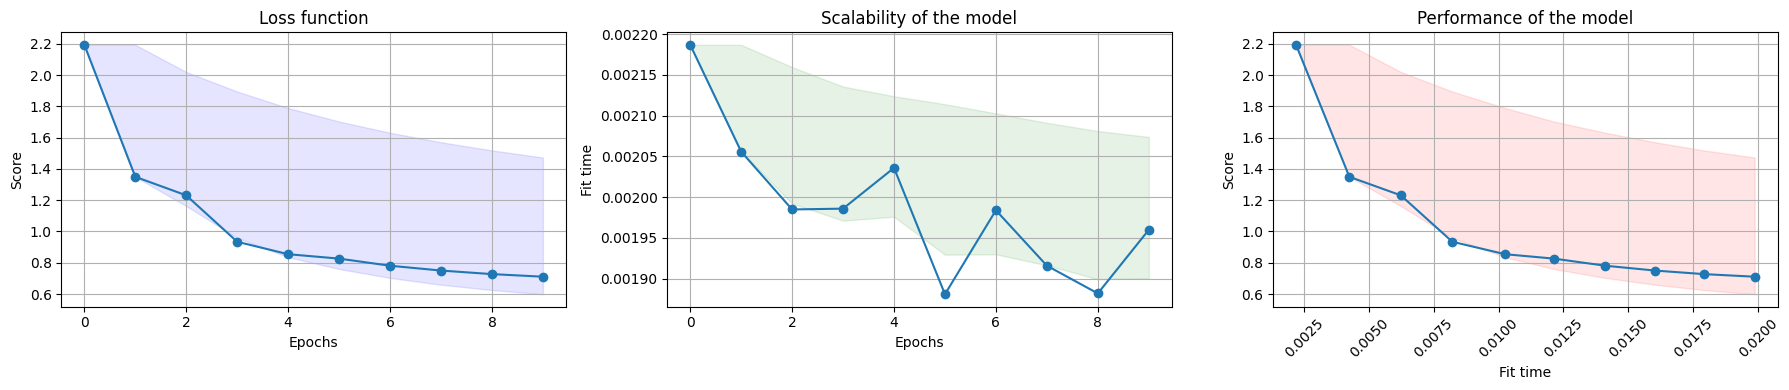

In [49]:
import matplotlib
prompt_tuner.plot_learning_curve()